<a href="https://colab.research.google.com/github/K-Domar/MyRepo/blob/main/Diamond_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

**Describe colums in dataset**

*price* - price in US dollars (\$326--\$18,823) **(TARGET)**

*carat* - weight of the diamond (0.2--5.01)

*cut* - quality of the cut (Fair, Good, Very Good, Premium, Ideal)

*color* - diamond colour, from J (worst) to D (best)

*clarity* -  a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

*x* - length in mm (0--10.74)

*y* - width in mm (0--58.9)

*z* - depth in mm (0--31.8)

*depth* - total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

*table* - width of top of diamond relative to widest point (43--95)

In [2]:
diamond = pd.read_csv('https://raw.githubusercontent.com/K-Domar/MyRepo/main/diamonds.csv')
diamond = diamond.loc[:,~diamond.columns.str.match("Unnamed")]
diamond.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [3]:
#Describe csv file
diamond.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [4]:
# check types of data in columns
diamond.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [5]:
# Looking for missing data

# Convert '0' to NaN
diamond[diamond==0] = np.nan

# Print the number of NaNs
print(diamond.isnull().sum())

carat       0
cut         0
color       0
clarity     0
depth       0
table       0
price       0
x           8
y           7
z          20
dtype: int64


In [6]:
# Drop the rows with missing values from diamond.csv
diamond = diamond.dropna()
diamond.shape

(53920, 10)

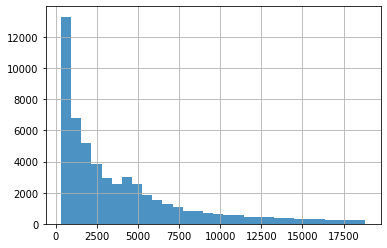

In [7]:
# Determine a problem type
diamond.price.hist(bins=30, alpha=0.8)
plt.show()


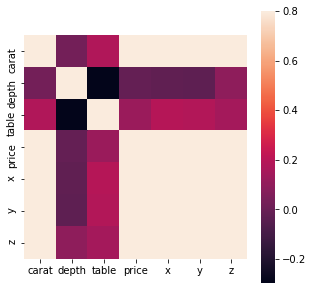

In [8]:
C_mat = diamond.corr()
fig = plt.figure(figsize = (5,5))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


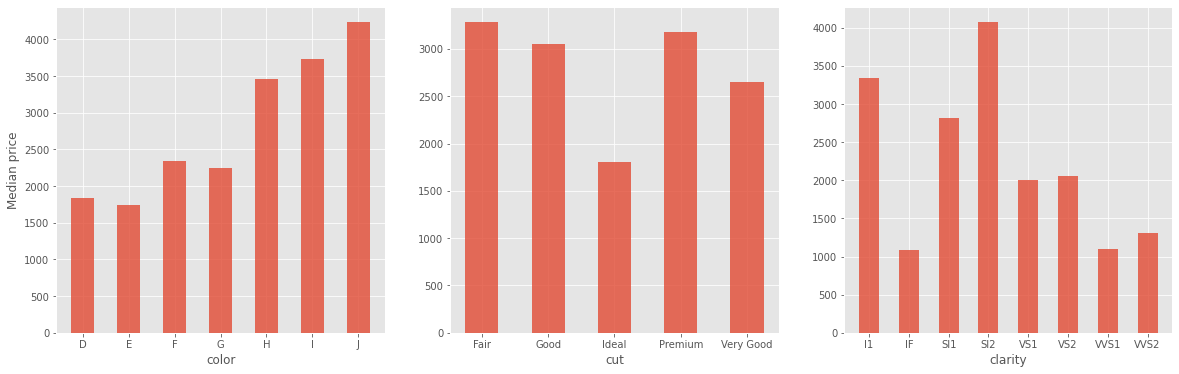

In [9]:
plt.style.use('ggplot')
# EDA for categorical features 
names = ['color', 'cut', 'clarity']
fig = plt.figure(figsize=(20, 6))
for i in range(0,3):
  
  parameters = diamond.groupby(names[i], as_index=False)['price'].median()
  plt.subplot(1, 3, i+1)
  plt.bar(parameters[names[i]], parameters.price, width=0.5, alpha=0.8)
  plt.xlabel(names[i])
plt.subplot(1,3,1)
plt.ylabel('Median price')
plt.show()


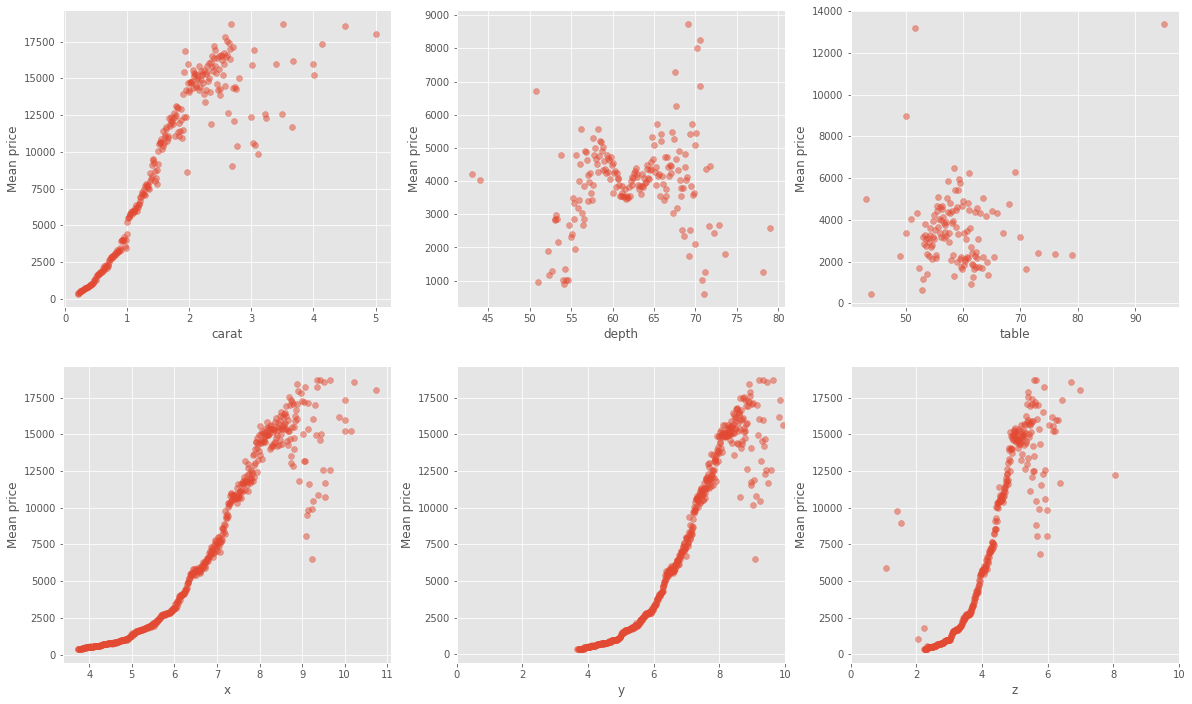

In [10]:
# EDA for numerical features

name = ['carat', 'depth', 'table', 'x', 'y', 'z']
fig = plt.figure(figsize=(20, 12))
for i in range(0,6):
  num_parameters = diamond.groupby(name[i], as_index=False)['price'].mean()
  plt.subplot(2, 3, i+1)
  plt.scatter(x=num_parameters[name[i]], y=num_parameters['price'], alpha=0.5)
  plt.xlabel(name[i])
  plt.ylabel('Mean price')
  if i > 3:
    plt.xlim(0, 10)
plt.show()

In [11]:
#Feature Engineering

#One_Hot encoding

ohe_cut = pd.get_dummies(diamond['cut'], prefix='cut')
ohe_color = pd.get_dummies(diamond['color'], prefix='color')
ohe_clarity = pd.get_dummies(diamond['clarity'], prefix='clarity')

diamond = pd.concat([diamond, ohe_cut], axis=1)
diamond = pd.concat([diamond, ohe_color], axis=1)
diamond = pd.concat([diamond, ohe_clarity], axis=1)

#drop colums with type 'object'
diamond = diamond.select_dtypes(exclude=['object'])
diamond.shape

(53920, 27)

In [12]:
#Training data
X = diamond.drop('price', axis=1)
y = diamond['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


SIMPLE REGRESSION MODEL

In [31]:
#Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_predicted = rf.predict(X_test)
rmse_rf = np.sqrt(MSE(y_test, y_predicted))
print("Root Mean Squared Error: {}".format(rmse_rf))
print("Score train = {0:.2f} %".format(rf.score(X_train, y_train)*100))
print("Score test = {0:.2f} %".format(rf.score(X_test, y_test)*100))

Root Mean Squared Error: 538.5976705633448
Score train = 99.73 %
Score test = 98.18 %


In [30]:
# Linear Regression

lr = LinearRegression(normalize=True)

lr.fit(X_train, y_train)
y_predicted = lr.predict(X_test)
rmse_lr = np.sqrt(MSE(y_test, y_predicted))
print("Root Mean Squared Error: {}".format(rmse_lr))
print("Score train = {0:.2f} %".format(lr.score(X_train, y_train)*100))
print("Score test = {0:.2f} %".format(lr.score(X_test, y_test)*100))

Root Mean Squared Error: 1123.2990550767981
Score train = 91.99 %
Score test = 92.08 %


In [29]:
#Lasso

lasso = Lasso(normalize=True)

lasso.fit(X_train, y_train)
y_predicted = lasso.predict(X_test)
rmse_lasso = np.sqrt(MSE(y_test, y_predicted))
print("Root Mean Squared Error: {}".format(rmse_lasso))
print("Score train = {0:.2f} %".format(lasso.score(X_train, y_train)*100))
print("Score test = {0:.2f} %".format(lasso.score(X_test, y_test)*100))

Root Mean Squared Error: 1406.4785597623927
Score train = 87.56 %
Score test = 87.59 %


A NEURAL NETWORK

In [16]:
# Building a model

model = Sequential()
model.add(Dense(52, activation='relu', input_shape=(26,)))
model.add(Dense(52, activation='relu'))
model.add(Dense(52, activation='relu'))
model.add(Dense(52, activation='relu'))
model.add(Dense(1))

# creat a metrics 
from keras import backend as K

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 52)                1404      
_________________________________________________________________
dense_1 (Dense)              (None, 52)                2756      
_________________________________________________________________
dense_2 (Dense)              (None, 52)                2756      
_________________________________________________________________
dense_3 (Dense)              (None, 52)                2756      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 53        
Total params: 9,725
Trainable params: 9,725
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Trainig model and scale values
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

early_stopping = EarlyStopping(monitor='val_loss', patience=6)

model_fit = model.fit(X_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping])

Epoch 1/100
432/432 [==============================] - 2s 3ms/step - loss: 17927355.2356 - coeff_determination: -0.1898 - val_loss: 1216209.5000 - val_coeff_determination: 0.9239
Epoch 2/100
432/432 [==============================] - 1s 2ms/step - loss: 722658.3541 - coeff_determination: 0.9516 - val_loss: 1086041.5000 - val_coeff_determination: 0.9323
Epoch 3/100
432/432 [==============================] - 1s 2ms/step - loss: 645950.2627 - coeff_determination: 0.9593 - val_loss: 983200.5625 - val_coeff_determination: 0.9389
Epoch 4/100
432/432 [==============================] - 1s 2ms/step - loss: 503619.5720 - coeff_determination: 0.9675 - val_loss: 910403.4375 - val_coeff_determination: 0.9434
Epoch 5/100
432/432 [==============================] - 1s 2ms/step - loss: 474822.7871 - coeff_determination: 0.9698 - val_loss: 852398.5000 - val_coeff_determination: 0.9470
Epoch 6/100
432/432 [==============================] - 1s 2ms/step - loss: 483721.9512 - coeff_determination: 0.9692 - v

In [32]:
# evaluate loaded model
scores_train = model.evaluate(X_train, y_train, verbose=0)
scores_test  = model.evaluate(X_test,  y_test,  verbose=0)

y_model = model.predict(X_test)
rmse = np.sqrt(MSE(y_test, y_model))
print("Root Mean Squared Error: {}".format(rmse))

print("Accuracy Train: %.2f%% , Test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))


Root Mean Squared Error: 620.3381394768837
Accuracy Train: 97.75% , Test: 97.48% 


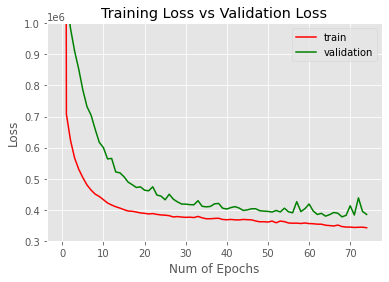

In [19]:
n_epochs = len(model_fit.history['loss'])

plt.figure(1)
plt.plot(model_fit.history['loss'],'r')
plt.plot(model_fit.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.ylim(300000,1000000) 
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

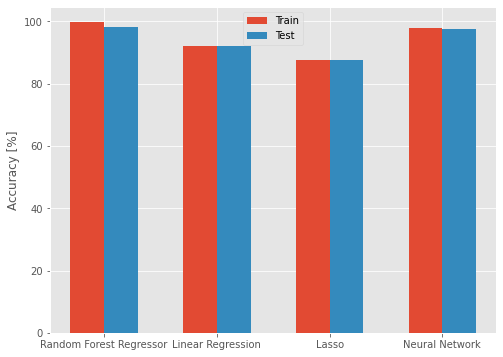

In [47]:
#Summary

labels = ['Random Forest Regressor', 'Linear Regression', 'Lasso', 'Neural Network']
accuracy_train = [rf.score(X_train,y_train)*100, lr.score(X_train,y_train)*100, lasso.score(X_train,y_train)*100, scores_train[1]*100]
accuracy_test = [rf.score(X_test,y_test)*100, lr.score(X_test,y_test)*100, lasso.score(X_test,y_test)*100, scores_test[1]*100]
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy_train, width, label='Train')
rects2 = ax.bar(x + width/2, accuracy_test, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy [%]')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()